In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import util

import fbprophet
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

mpl.rcParams['figure.figsize'] = (16, 8)
mpl.rcParams['axes.grid'] = False

# Read Data

In [2]:
df = pd.read_csv('cat9300_show_active_asic_cat9300_new.csv')

In [3]:
df.head()

,Time,DeviceName,Desc,MaxVal1,MaxVal2,Used1,Used2
0,1.574920e+18,Unicast MAC addresses,32768,1024,25,21,NaN
1,1.574920e+18,L3 Multicast entries,8192,512,0,9,NaN
2,1.574920e+18,L2 Multicast entries,8192,512,0,11,NaN
3,1.574920e+18,Directly or indirectly connected routes,24576,8192,51,153,NaN
4,1.574920e+18,QoS Access Control Entries,5120,0,85,0,NaN


Remove rows with no device name column

In [4]:
df = df[42222:]

In [5]:
df.head()

,Time,DeviceName,Desc,MaxVal1,MaxVal2,Used1,Used2
42222,1.575000e+18,cat9300,L2 Multicast entries,8192,512,0,11.0
42223,1.575000e+18,cat9300,Directly or indirectly connected routes,24576,8192,235,153.0
42224,1.575000e+18,cat9300,QoS Access Control Entries,5120,0,85,0.0
42225,1.575000e+18,cat9300,Security Access Control Entries,5120,0,2598,0.0
42226,1.575000e+18,cat9300,Ingress Netflow ACEs,256,0,6,0.0


In [6]:
len(df)

1006353

Get Security Access Control Entries data

In [8]:
sace_data = df[df['Desc'] == 'Security Access Control Entries']
ace = pd.DataFrame(sace_data, columns=['Time', 'Used1'])
ace['Time'] = pd.to_datetime(ace['Time'],unit='ns')

In [9]:
ace.head()

,Time,Used1
42225,2019-11-29 04:00:00,2598
42245,2019-11-29 04:00:00,2598
42265,2019-11-29 04:00:00,2598
42285,2019-11-29 04:00:00,2598
42305,2019-11-29 04:00:00,2598


In [10]:
ace.tail()

,Time,Used1
1048485,2019-12-12 03:06:40,212
1048505,2019-12-12 03:06:40,212
1048525,2019-12-12 03:06:40,212
1048545,2019-12-12 03:06:40,212
1048565,2019-12-12 03:06:40,212


In [11]:
ace.reset_index(drop=True, inplace=True)
ace.head()

,Time,Used1
0,2019-11-29 04:00:00,2598
1,2019-11-29 04:00:00,2598
2,2019-11-29 04:00:00,2598
3,2019-11-29 04:00:00,2598
4,2019-11-29 04:00:00,2598


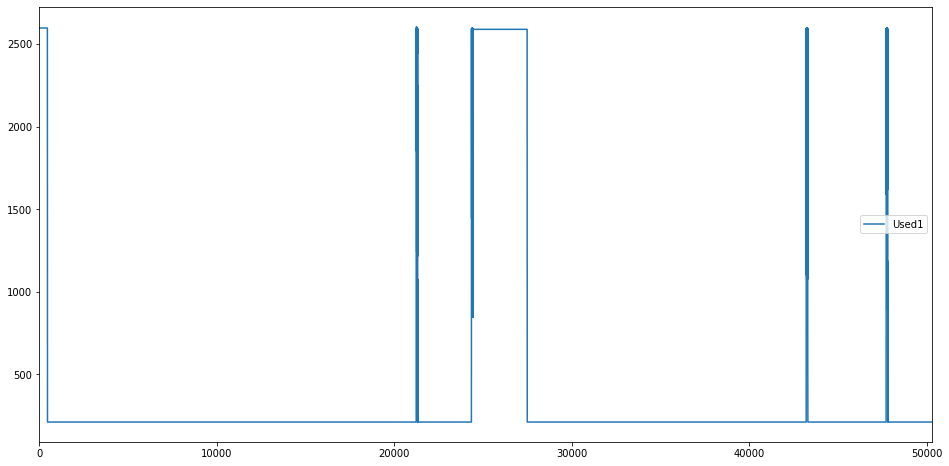

In [12]:
ace.plot(y='Used1')

In [13]:
len(ace['Used1'])

50318

Lets visualize data having more variations

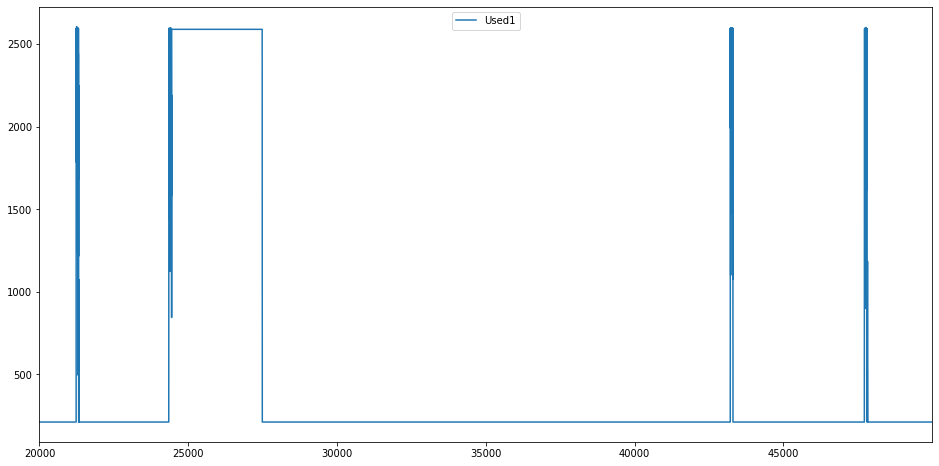

In [14]:
ace.iloc[20000:50000].plot(y='Used1')

In [15]:
small_data = ace.iloc[20000:50000]

In [16]:
len(small_data)

30000

# Prophet

Rename Datetime column as 'ds' and values column as 'y'

In [17]:
small_data = small_data.rename(columns={'Time' : 'ds', 'Used1' : 'y'})

In [18]:
small_data.head()

,ds,y
20000,2019-12-04 11:46:40,212
20001,2019-12-04 11:46:40,212
20002,2019-12-04 11:46:40,212
20003,2019-12-04 11:46:40,212
20004,2019-12-04 11:46:40,212


In [19]:
small_data.tail()

,ds,y
49995,2019-12-12 00:20:00,212
49996,2019-12-12 00:20:00,212
49997,2019-12-12 00:20:00,212
49998,2019-12-12 00:20:00,212
49999,2019-12-12 00:20:00,212


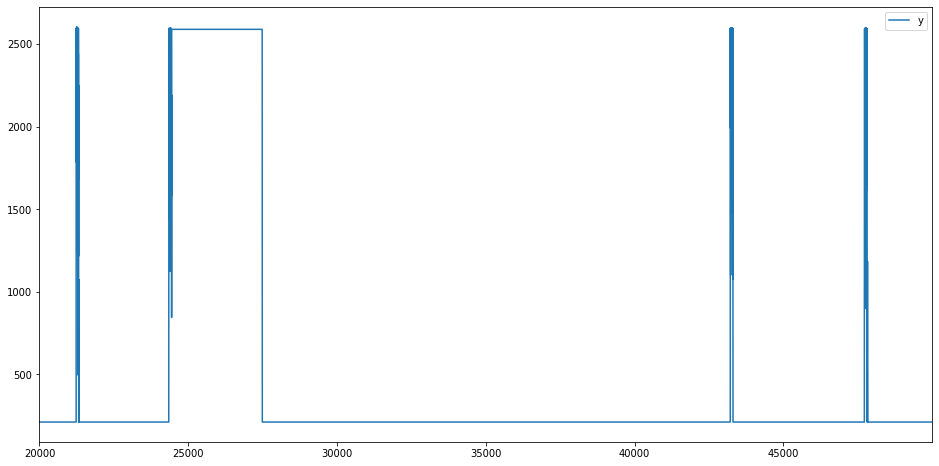

In [20]:
small_data.plot(y='y')

Create and train the model.

In prophet, the changepoint_prior_scale parameter is used to control how sensitive the trend is to changes, with a higher value being more sensitive and a lower value less sensitive.

In [21]:
df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.10)
df_prophet.fit(small_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


To make forecasts, we need to create what is called a future dataframe. We specify the number of future periods to predict (5 days in our case) and the frequency of predictions (D - daily). We then make predictions with the prophet model we created and the future dataframe.

In [22]:
forecast = df_prophet.make_future_dataframe(periods=5, freq='D')
prediction = df_prophet.predict(forecast)

Lets plot the prediction. The black dots represent the actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty.

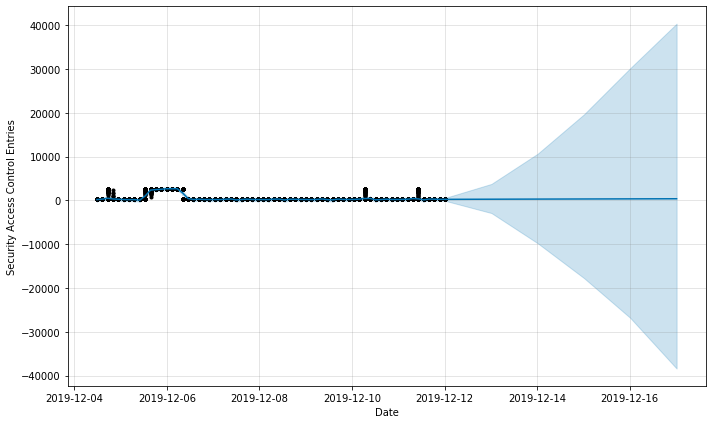

In [23]:
df_prophet.plot(prediction, xlabel='Date', ylabel='Security Access Control Entries');

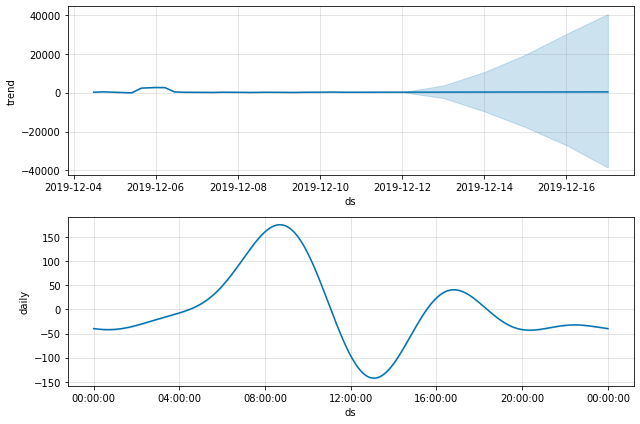

In [24]:
df_prophet.plot_components(prediction);

# Predict for next 1 day 

Create and train the model.

In prophet, the changepoint_prior_scale parameter is used to control how sensitive the trend is to changes, with a higher value being more sensitive and a lower value less sensitive.

In [25]:
df_prophet = fbprophet.Prophet()
df_prophet.fit(small_data)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


To make forecasts, we need to create what is called a future dataframe. We specify the number of future periods to predict (5 days in our case) and the frequency of predictions (D - daily). We then make predictions with the prophet model we created and the future dataframe.

In [26]:
forecast = df_prophet.make_future_dataframe(periods=1, freq='D')
prediction = df_prophet.predict(forecast)

Lets plot the prediction. The black dots represent the actual values, the blue line indicates the forecasted values, and the light blue shaded region is the uncertainty.

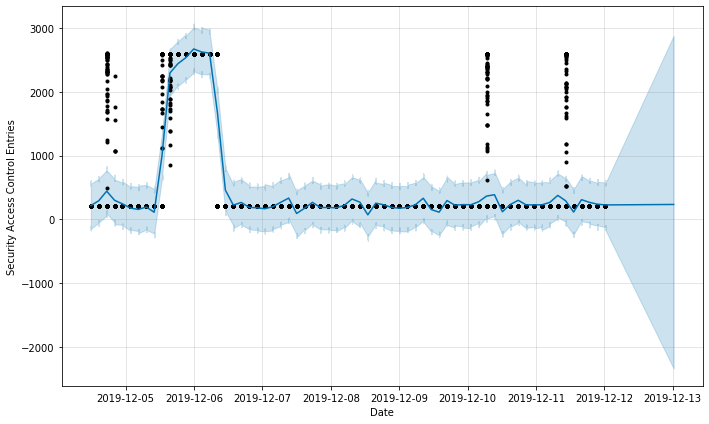

In [27]:
df_prophet.plot(prediction, xlabel='Date', ylabel='Security Access Control Entries');

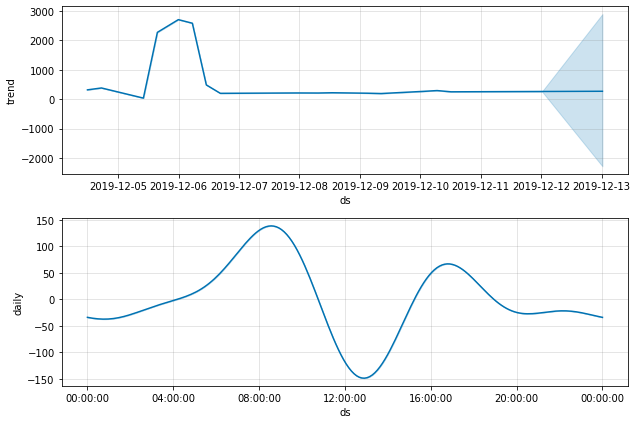

In [28]:
df_prophet.plot_components(prediction);

The model accuracy is less but it has the feature to show daily, weekly, yearly trends

# LSTM

In [29]:
small_data.head()

,ds,y
20000,2019-12-04 11:46:40,212
20001,2019-12-04 11:46:40,212
20002,2019-12-04 11:46:40,212
20003,2019-12-04 11:46:40,212
20004,2019-12-04 11:46:40,212


In [30]:
small_data = small_data.rename(columns={'ds':'Time', 'y':'Used1'})

LSTMs are sensitive to the scale of the input data, specifically when the sigmoid or tanh activation functions are used. It’s generally a good practice to rescale the data to the range of [0, 1] or [-1, 1], also called normalizing. 

In [31]:
values = small_data['Used1'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(values)

In [32]:
scaled

array([[0.],
       [0.],
       [0.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

Split data into train and test set

In [33]:
train_size = int(len(scaled) * 0.8)
test_size = len(scaled) - train_size
train, test = scaled[:train_size, :], scaled[train_size:, :]
print(len(train), len(test))

24000 6000


In [34]:
def create_dataset(dataset, look_back = 1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
        
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [35]:
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

23998
5998


In [36]:
trainX, trainY

(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [37]:
testX, testY

(array([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]], dtype=float32),
 array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [38]:
print(trainX.shape, trainY.shape, testX.shape, testY.shape)

(23998, 2) (23998,) (5998, 2) (5998,)


The LSTM network expects the input data to be provided with a specific array structure in the form of: [samples, time steps, features].
Our data is currently in the form [samples, features] and we are framing the problem as two time steps for each sample.

In [39]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
print(trainX.shape, testX.shape)

(23998, 1, 2) (5998, 1, 2)


In [40]:
model = Sequential()
model.add(LSTM(100, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(trainX, trainY, epochs=20, batch_size=100, validation_data=(testX, testY), shuffle=False)

Train on 23998 samples, validate on 5998 samples
Epoch 1/20
23998/23998 [==============================] - 3s 127us/sample - loss: 0.0709 - val_loss: 0.0025
Epoch 2/20
23998/23998 [==============================] - 1s 36us/sample - loss: 0.0057 - val_loss: 8.4817e-04
Epoch 3/20
23998/23998 [==============================] - 1s 36us/sample - loss: 7.6504e-04 - val_loss: 8.3132e-04
Epoch 4/20
23998/23998 [==============================] - 1s 36us/sample - loss: 7.0963e-04 - val_loss: 8.3059e-04
Epoch 5/20
23998/23998 [==============================] - 1s 38us/sample - loss: 7.0389e-04 - val_loss: 8.2999e-04
Epoch 6/20
23998/23998 [==============================] - 1s 36us/sample - loss: 7.0239e-04 - val_loss: 8.2925e-04
Epoch 7/20
23998/23998 [==============================] - 1s 35us/sample - loss: 7.0148e-04 - val_loss: 8.2835e-04
Epoch 8/20
23998/23998 [==============================] - 1s 36us/sample - loss: 7.0075e-04 - val_loss: 8.2702e-04
Epoch 9/20
23998/23998 [==================

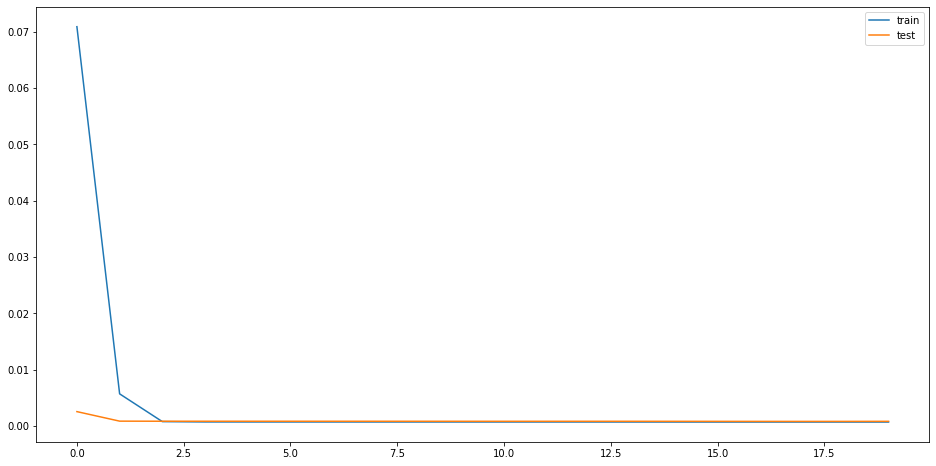

In [41]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

Make Predictions

In [42]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
Y_train = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
Y_test = scaler.inverse_transform([testY])

In [43]:
print('Train Mean Absolute Error:', mean_absolute_error(Y_train[0], train_predict[:,0]))
print('Train Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_train[0], train_predict[:,0])))
print('Test Mean Absolute Error:', mean_absolute_error(Y_test[0], test_predict[:,0]))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(Y_test[0], test_predict[:,0])))

Train Mean Absolute Error: 20.83802452237178
Train Root Mean Squared Error: 64.49108878397561
Test Mean Absolute Error: 17.98174206518348
Test Root Mean Squared Error: 68.36640107521602


Compare Actual vs Prediction

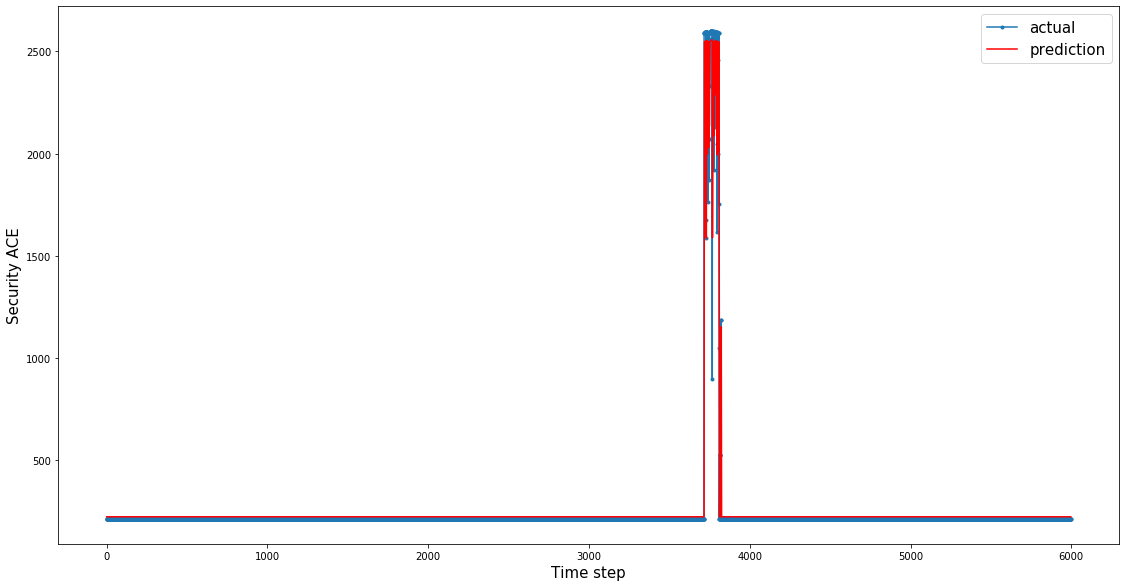

In [54]:
aa=[x for x in range(len(testY))]
plt.plot(aa, Y_test[0], marker='.', label="actual")
plt.plot(aa, test_predict[:,0], 'r', label="prediction")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Security ACE', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();

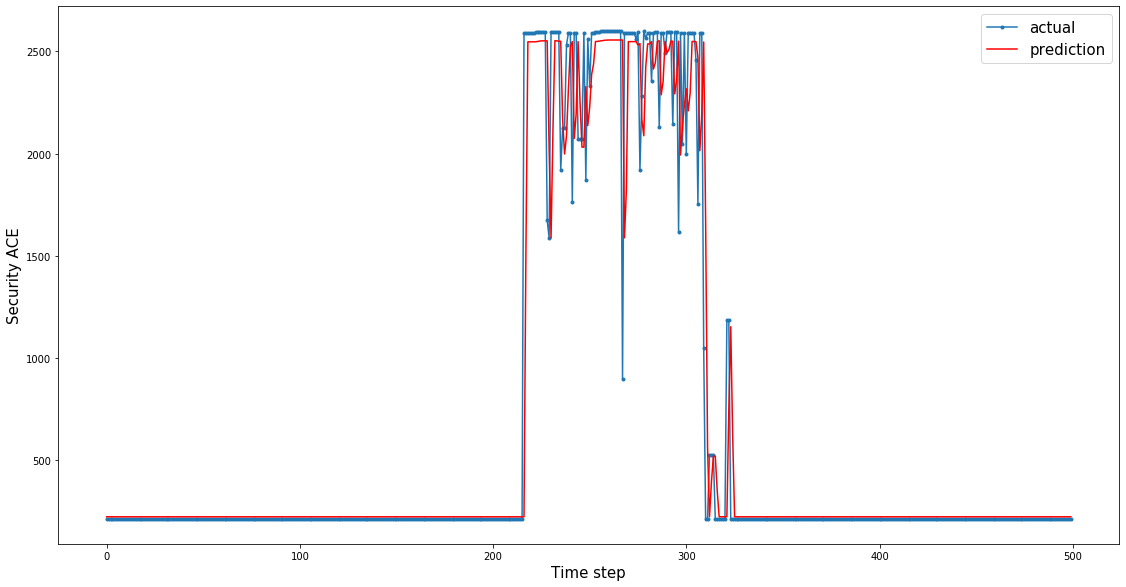

In [55]:
aa=[x for x in range(500)]
plt.plot(aa, Y_test[0][3500:4000], marker='.', label="actual")
plt.plot(aa, test_predict[3500:4000,0], 'r', label="prediction")
plt.tight_layout()
plt.subplots_adjust(left=0.07)
plt.ylabel('Security ACE', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show();